
# Assignment 10: Adversarial Examples & Training - Kai Ponel & Hannan Mahadik

# Imports & Google Drive

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, InputLayer

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir('/content/drive/MyDrive/ColabNotebooks/IDL_Hannan_Kai/Task 10')

Mounted at /content/drive


# CIFAR10 Dataset

		frog


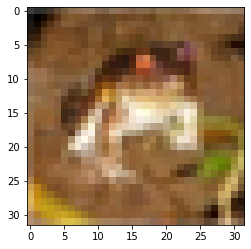

In [ ]:
### Loading the CIFAR-10 Dataset for the mandatory task

cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

label_def = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(train_images[0])
print('\t\t' + label_def[train_labels[0][0]])

In [ ]:
### Dataset stuff

train_images = train_images.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.
test_images = test_images.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.

train_images_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_labels_ds = tf.data.Dataset.from_tensor_slices(train_labels)

train_data = tf.data.Dataset.zip((train_images_ds, train_labels_ds))

BATCH_SIZE = 256

batched_train_data = train_data.batch(BATCH_SIZE)

# Early Stopping Callback

In [ ]:
### Define the early stopping callback (This is used in multiple models)
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  patience=3,  
  restore_best_weights=True  
)

# Model

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

In [ ]:
### Hyperparameters
initializer = tf.keras.initializers.HeNormal()
regularizer = tf.keras.regularizers.L2(1e-4)

In [ ]:
### A simple CNN model for classifying the CIFAR10 images
model = Sequential([
  # InputLayer(32,32,3),
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
  InputLayer(32,32,3),
  Conv2D(32, 3, activation='relu', kernel_regularizer=regularizer, kernel_initializer=initializer),
  MaxPooling2D((2, 2)),
  Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizer, kernel_initializer=initializer),
  MaxPooling2D((2, 2)),
  Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizer, kernel_initializer=initializer),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(10, activation='softmax')
])

In [ ]:
### Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
### Train!
model.fit(train_images, train_labels, epochs=100, batch_size=128, validation_data=(test_images,test_labels), callbacks=[early_stopping])

Epoch 1/100
391/391 [==============================] - 38s 93ms/step - loss: 1.8748 - sparse_categorical_accuracy: 0.3318 - val_loss: 1.6950 - val_sparse_categorical_accuracy: 0.3993
Epoch 2/100
391/391 [==============================] - 37s 94ms/step - loss: 1.6245 - sparse_categorical_accuracy: 0.4257 - val_loss: 1.5912 - val_sparse_categorical_accuracy: 0.4376
Epoch 3/100
391/391 [==============================] - 36s 93ms/step - loss: 1.5145 - sparse_categorical_accuracy: 0.4676 - val_loss: 1.4400 - val_sparse_categorical_accuracy: 0.4996
Epoch 4/100
391/391 [==============================] - 36s 93ms/step - loss: 1.4360 - sparse_categorical_accuracy: 0.5005 - val_loss: 1.4111 - val_sparse_categorical_accuracy: 0.5120
Epoch 5/100
391/391 [==============================] - 36s 92ms/step - loss: 1.3750 - sparse_categorical_accuracy: 0.5241 - val_loss: 1.3271 - val_sparse_categorical_accuracy: 0.5506
Epoch 6/100
391/391 [==============================] - 36s 93ms/step - loss: 1.3132 -

# Adversarial Test

In [ ]:
### Function which takes a model with images and labels => Computes gradient of the loss in respect to the input
def run_model(model, images, labels):
  with tf.GradientTape() as tape:
    tape.watch(images)
    out = model(images, training = False)
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(labels, out)

  gradients = tape.gradient(cross_entropy, images)

  return gradients, cross_entropy, out

In [ ]:
### Get some data from the training dataset
for step, (image_batch, label_batch) in enumerate(train_data):
  break

In [ ]:
### Run the adversarial test and print the different classifications for the normal and adversarial example
gradient_images, loss, predictions = run_model(model, image_batch, label_batch)

print("Prediction on 1st input:", label_def[[np.argmax(predictions[0].numpy())][0]])

EPSILON = 0.02 # Higher => Bigger changes to each pixel

# 1. For each pixel in the input: Add EPSILON*Sign(grad(loss, input))
# 2. Clip values between 0 and 1 to ensure valuerange of [0,1] is maintained 
adversarial_images = tf.clip_by_value(image_batch + EPSILON*tf.math.sign(gradient_images), 0., 1.)

# Run the model again on the new image 
adv_images, adv_loss, adv_predictions = run_model(model, adversarial_images, label_batch)

# Compare the labels of the classification on the normal image vs. the adversarial image
print("Prediction on 1st adversarial input:", label_def[[np.argmax(adv_predictions[0].numpy())][0]])
print("Correct label:", label_def[label_batch[0].numpy()[0]])

Prediction on 1st input: frog
Prediction on 1st adversarial input: dog
Correct label: frog


In [ ]:
### Function which takes a model, image batch and labels; Returns adversarial images using the gradiant sign method
def adv_images(model, batch, labels, epsilon = 0.02):
  # Get the gradient for the inputs in respect to the labels
  gradients, _, _ = run_model(model, batch, labels)

  # 1. For each pixel in the input: Add EPSILON*Sign(grad(loss, input))
  # 2. Clip values between 0 and 1 to ensure valuerange of [0,1] is maintained 
  adversarial_batch = tf.clip_by_value(batch + epsilon*tf.math.sign(gradients), 0., 1.)

  return adversarial_batch

In [ ]:
### Get the predictions of the model using normal and adversarial examples
batch_predictions = tf.argmax(model(image_batch, training = False), axis = 1)

adversarial_batch = adv_images(model, tf.convert_to_tensor(image_batch), label_batch)

adv_predictions = tf.argmax(model.predict_on_batch(adversarial_batch), axis = 1)

8/8 [==============================] - 0s 4ms/step - loss: 1.0626 - sparse_categorical_accuracy: 0.6406
On unchanged batch: 


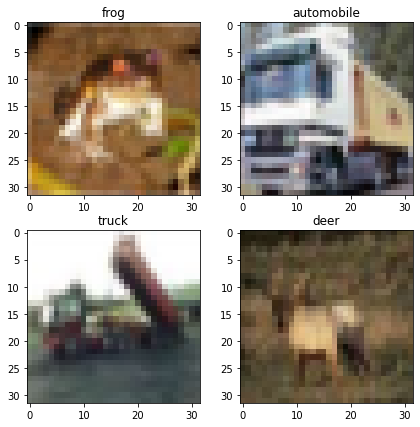

In [ ]:
### Plot results of col*rows images for normal images
fig = plt.figure(figsize=(7,7))
columns = 2
rows = 2

print(f"On unchanged batch: ".format(model.evaluate(image_batch, label_batch)))

for i in range(1, columns*rows + 1):
  img = tf.cast(image_batch[i-1] * 255, tf.int32)
  fig.add_subplot(rows, columns, i)
  plt.title(label_def[batch_predictions.numpy()[i-1]])
  plt.imshow(img)

plt.show()

8/8 [==============================] - 0s 3ms/step - loss: 4.2230 - sparse_categorical_accuracy: 0.0625
On adversarial batch: 


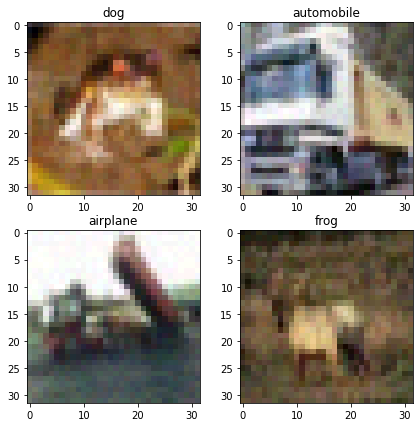

In [ ]:
### Plot results of col*rows images for adversarial images
adv_fig = plt.figure(figsize=(7,7))
columns = 2
rows = 2

print(f"On adversarial batch: ".format(model.evaluate(adversarial_batch, label_batch)))

for i in range(1, columns*rows + 1):
  img = tf.cast(adversarial_batch[i-1] * 255, tf.int32)
  adv_fig.add_subplot(rows, columns, i)
  plt.title(label_def[adv_predictions.numpy()[i-1]])
  plt.imshow(img)

plt.show()

# Adversarial Training

In [ ]:
### reformat train data, generate adversarial examples, reformat test data
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000).batch(BATCH_SIZE)

aug_train_data = train_data.map(lambda x, y: (adv_images(model, x, y), y))

test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

In [ ]:
### Train the model on the adversarial examples
model.fit(aug_train_data, epochs=100, batch_size=BATCH_SIZE, validation_data=test_data, callbacks=[early_stopping])

Epoch 1/100
196/196 [==============================] - 92s 468ms/step - loss: 1.4959 - sparse_categorical_accuracy: 0.4740 - val_loss: 1.1759 - val_sparse_categorical_accuracy: 0.6083
Epoch 2/100
196/196 [==============================] - 91s 467ms/step - loss: 1.4641 - sparse_categorical_accuracy: 0.4867 - val_loss: 1.1569 - val_sparse_categorical_accuracy: 0.6131
Epoch 3/100
196/196 [==============================] - 91s 464ms/step - loss: 1.4436 - sparse_categorical_accuracy: 0.4931 - val_loss: 1.1734 - val_sparse_categorical_accuracy: 0.6047
Epoch 4/100
196/196 [==============================] - 91s 463ms/step - loss: 1.4323 - sparse_categorical_accuracy: 0.4990 - val_loss: 1.1435 - val_sparse_categorical_accuracy: 0.6254
Epoch 5/100
196/196 [==============================] - 91s 463ms/step - loss: 1.4253 - sparse_categorical_accuracy: 0.4979 - val_loss: 1.1528 - val_sparse_categorical_accuracy: 0.6155
Epoch 6/100
196/196 [==============================] - 91s 464ms/step - loss: 1.

In [ ]:
# Original Model
model.evaluate(test_data)

40/40 [==============================] - 0s 7ms/step - loss: 1.2292 - sparse_categorical_accuracy: 0.5906


[1.2292276620864868, 0.5906000137329102]

In [ ]:
# After Adversarial Training
model.evaluate(test_data)

40/40 [==============================] - 0s 7ms/step - loss: 1.1435 - sparse_categorical_accuracy: 0.6254


[1.1435426473617554, 0.6254000067710876]

# Bonus

## Additional Imports

In [ ]:
# Data
from keras.preprocessing.image import ImageDataGenerator

# Data Viz
import seaborn as sns
import plotly.express as px

# Other 
from glob import glob
from tqdm import tqdm 

## Animal-10 Dataset
*Note: Parts of the implementation for loading the dataset are based of [this notebook](https://www.kaggle.com/code/utkarshsaxenadn/animal-10-classification-resnet152v2-acc-93)*. The dataset we used can be found on [kaggle](https://www.kaggle.com/datasets/alessiocorrado99/animals10) aswell.

Also note: Due to memory limitations in Colab we did the following adjustments to the Animal-10 (256x256 Dataset):
1. We reduced the size of the images from 256x256 to 128x128
2. We reduced the amount of classes to 4 instead of 10 (_Animal-4_)

In [ ]:
### Define the location of the dataset and load the classes from the directory names
path = './external_data/animal10/raw-img/'

# Get Class Names
class_names = sorted(os.listdir(path))
n_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {n_classes}")

Class Names: 
['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Total Number of Classes : 10


In [ ]:
### Some statistics about the classes and their distribution in the dataset
class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()

Class Distribution : 
[4863, 2623, 1446, 2112, 3098, 1668, 1866, 1820, 4821, 1862]


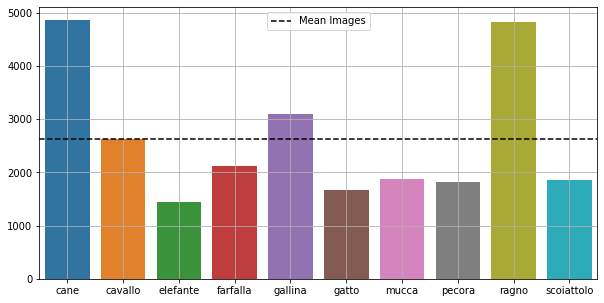

In [ ]:
### Different graphs :> 
plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=class_dis)
plt.grid()
plt.axhline(np.mean(class_dis), color='k', linestyle='--', label="Mean Images")
plt.legend()
plt.show()

In [ ]:
### Generator for the dataset. Each time a new batch is needed it is being loaded of the drive storage 
# Initialize Generator 
gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=20, 
    validation_split=0.2)

# Load training data
train_ds2 = gen.flow_from_directory(
    path, 
    target_size=(128,128), # Change 1: Reduce the image size to 128x128
    batch_size=64, 
    classes = ['elefante', 'farfalla', 'gallina', 'gatto'], # Change 2: Change the amount of classes
    class_mode = 'categorical',
    shuffle=True, 
    subset='training')

# Load validation data
valid_ds2 = gen.flow_from_directory(
    path, 
    target_size=(128,128),  # Change 1: Reduce the image size to 128x128
    batch_size=64, 
    classes = ['elefante', 'farfalla', 'gallina', 'gatto'], # Change 2: Change the amount of classes
    class_mode = 'categorical',
    shuffle=True, 
    subset='validation')

Found 6661 images belonging to 4 classes.
Found 1663 images belonging to 4 classes.


In [ ]:
### Custom label definition since we reduced the amount of classes (and because the originals are in italian)
label_def2 = ['elephant', 'butterfly', 'hen', 'cat'] 

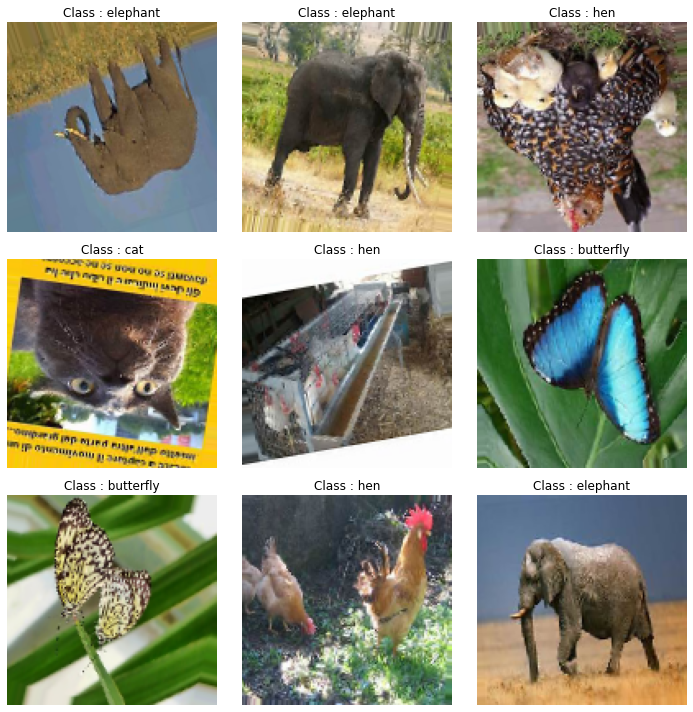

In [ ]:
### Some Visualization of the dataset ###
def show_image(img, title=None):
    '''The function takes in a Image and plots it'''
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')


def get_random_data(data):
    images, labels = data
    id = np.random.randint(len(images))
    image, label = images[id], labels[id]
    return image, label

plt.figure(figsize=(10,10))
i=1
for images, labels in iter(train_ds2):
    
    # Get Random Image and label
    image, label = get_random_data([images, labels])
    
    # Plot it
    plt.subplot(3,3,i)
    
    show_image(image, title=f"Class : {label_def2[int(np.argmax(label))]}")
    
    # Make sure to end the Loop
    i+=1
    if i>9: break
        

plt.tight_layout()
plt.show()

In [ ]:
### Shape test (Debug, to be discarded)
for images, labels in iter(train_ds2):
    
    # Get Random Image and label
    image, label = get_random_data([images, labels])
    break
print(image.shape)

(128, 128, 3)


## Model

In [ ]:
### Import different pre-trained models from Keras to play around with
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
### Load the pre-trained models
densenet121 = tf.keras.applications.DenseNet121(
    input_shape=(128, 128, 3),
    weights="imagenet",
    include_top=False
)

inceptionv3 = tf.keras.applications.InceptionV3(
    input_shape=(128, 128, 3),
    weights="imagenet",
    include_top=False
)

In [ ]:
# Model 1: Densenet -> Flatten -> Softmax classification head
model1 = Sequential([
    densenet121,
    Flatten(),
    Dense(4, activation='softmax')
])

# Model 2: Inception -> Flatten -> Softmax classification head
model2 = Sequential([
    inceptionv3,
    Flatten(),
    Dense(4, activation='softmax')
])

In [ ]:
### Construction the ensemble model consisting of the models defined above
models = [model1, model2]
# Uniform input layer for all Models (Note: We downscaled the images in the datagenerator from 256x256 to 128x128 due to memory issues)
model_input = tf.keras.Input(shape=(128, 128, 3))
# Output of each model
model_outputs = [model(model_input) for model in models]
# The output of the final (ensembled) model is the average of the outputs of the individual models
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs = ensemble_output)

In [ ]:
ensemble_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=tf.keras.metrics.CategoricalAccuracy())

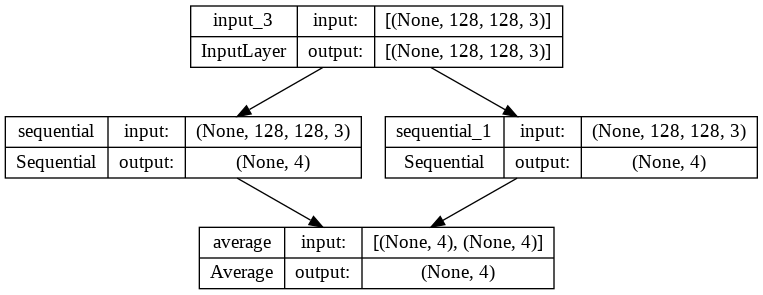

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(ensemble_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
ensemble_model.fit(train_ds2, epochs=20, batch_size=64, validation_data=valid_ds2, callbacks=[early_stopping])

# Interesting observation: The validation accuracy appears to drop on some epochs. Maybe this happens on some specific parts of the validation set?

Epoch 1/20
105/105 [==============================] - 113s 825ms/step - loss: 0.8775 - categorical_accuracy: 0.5543 - val_loss: 9.1144 - val_categorical_accuracy: 0.2538
Epoch 2/20
105/105 [==============================] - 74s 705ms/step - loss: 0.7583 - categorical_accuracy: 0.5522 - val_loss: 2.9744 - val_categorical_accuracy: 0.4726
Epoch 3/20
105/105 [==============================] - 73s 695ms/step - loss: 0.5964 - categorical_accuracy: 0.6215 - val_loss: 2.9348 - val_categorical_accuracy: 0.2712
Epoch 4/20
105/105 [==============================] - 78s 738ms/step - loss: 0.6251 - categorical_accuracy: 0.5862 - val_loss: 2.0103 - val_categorical_accuracy: 0.3187
Epoch 5/20
105/105 [==============================] - 74s 699ms/step - loss: 0.7073 - categorical_accuracy: 0.5040 - val_loss: 3.2780 - val_categorical_accuracy: 0.2538
Epoch 6/20
105/105 [==============================] - 73s 689ms/step - loss: 0.6008 - categorical_accuracy: 0.5583 - val_loss: 0.6402 - val_categorical_ac

In [ ]:
# Original Model
normal_val_loss, normal_val_acc = ensemble_model.evaluate(valid_ds2)

26/26 [==============================] - 10s 392ms/step - loss: 0.5214 - categorical_accuracy: 0.5460


## Adversarial Test

In [ ]:
### Get some training images and labels from the dataset generator
for step, (image_batch2, label_batch2) in enumerate(train_ds2):
  break

In [ ]:
### Get the predictions for the normal images
batch_predictions2 = tf.argmax(ensemble_model(image_batch2, training = False), axis = 1)

2/2 [==============================] - 0s 80ms/step - loss: 0.7783 - categorical_accuracy: 0.6562
On unchanged batch: 


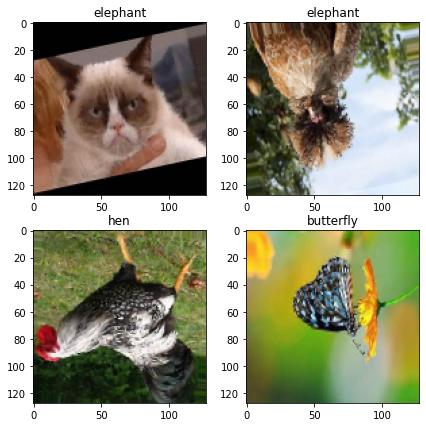

In [ ]:
### Plot the results for the normal images
fig = plt.figure(figsize=(7,7))
columns = 2
rows = 2

print(f"On unchanged batch: ".format(ensemble_model.evaluate(image_batch2, label_batch2)))

for i in range(1, columns*rows + 1):
  img = tf.cast(image_batch2[i-1] * 255, tf.int32)
  fig.add_subplot(rows, columns, i)
  plt.title(label_def2[batch_predictions2.numpy()[i-1]])
  plt.imshow(img)

plt.show()

In [ ]:
### Function which takes images and labels => Computes gradient of the loss in respect to the input for the ensemble model
def run_model2(images2, labels):
  with tf.GradientTape() as tape:
    tape.watch(images2)
    out = ensemble_model(images2, training = False)
    cross_entropy = tf.keras.losses.categorical_crossentropy(labels, out)

  gradients = tape.gradient(cross_entropy, images2)

  return gradients, cross_entropy, out

In [ ]:
### Function which takes a model, image batch and labels; Returns adversarial images using the gradient sign method
def adv_images2(model, batch, labels, epsilon = 0.02):

  # Get the gradient of the inputs in respect to the labels
  gradients, _, _ = run_model2(batch, labels) # (We only need the gradient from the function)

  # 1. For each pixel in the input: Add EPSILON*Sign(grad(loss, input))
  # 2. Clip values between 0 and 1 to ensure valuerange of [0,1] is maintained 
  adversarial_batch = tf.clip_by_value(batch + epsilon*tf.math.sign(gradients), 0., 1.)

  return adversarial_batch

In [ ]:
### Create one adversarial batch and get the predictions for them
adversarial_batch2 = adv_images2(ensemble_model, tf.convert_to_tensor(image_batch2), label_batch2)

adv_predictions2 = tf.argmax(ensemble_model(adversarial_batch2, training = False), axis = 1)

2/2 [==============================] - 0s 68ms/step - loss: 2.5215 - categorical_accuracy: 0.1719
On adversarial batch: 


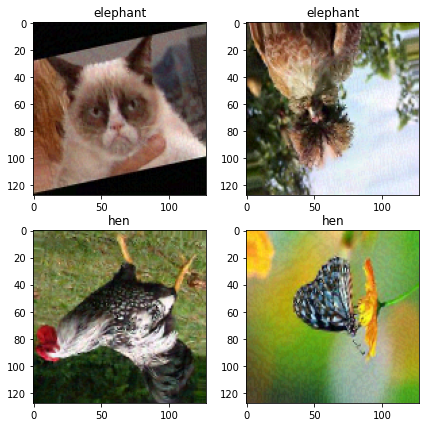

In [ ]:
### Plot the results for the adversarial images
adv_fig = plt.figure(figsize=(7,7))
columns = 2
rows = 2

print(f"On adversarial batch: ".format(ensemble_model.evaluate(adversarial_batch2, label_batch2)))

for i in range(1, columns*rows + 1):
  img = tf.cast(adversarial_batch2[i-1] * 255, tf.int32)
  adv_fig.add_subplot(rows, columns, i)
  plt.title(label_def2[adv_predictions2.numpy()[i-1]])
  plt.imshow(img)

plt.show()

## Adversarial Training

In [ ]:
### Create the adversarial data for the animal-4 ds 

aug_train_data2_images = []
aug_train_data2_labels = []

# Note: This has to be limited due to memory limitations on collab. 
# Loading the entire dataset into a memory with the other one still being loaded and the models causes 
# OOM issues. This means that the adversarial training takes place on a subset of the training data 
max_batches = 256

for index, (x,y) in enumerate(train_ds2):
  # Upon reaching the defined limit (Dependent on what Colab allows) => Stop generating adversarial examples
  if index >= max_batches:
    break
  # Converting np.ndarrays to Tensors
  x = tf.convert_to_tensor(x)
  y = tf.convert_to_tensor(y)
  # Add the adversarial data
  aug_train_data2_images.append(adv_images2(ensemble_model, x, y))
  aug_train_data2_labels.append(y)

# Flatten the nested lists into one big Tensor
aug_train_data2_images = tf.convert_to_tensor([a for b in aug_train_data2_images for a in b])
aug_train_data2_labels = tf.convert_to_tensor([a for b in aug_train_data2_labels for a in b])

In [ ]:
## Convert adversarial Data to a dataset ready to be fed into the model
aug_train_ds_images = tf.data.Dataset.from_tensor_slices(aug_train_data2_images)
aug_train_ds_labels = tf.data.Dataset.from_tensor_slices(aug_train_data2_labels)

print("[DEBUG] Shape of the images: {}".format(aug_train_data2_images.shape))
print("[DEBUG] Shape of the labels: {}".format(aug_train_data2_labels.shape))

# Finally, create the dataset from the tensors defined above 
ds = tf.data.Dataset.from_tensor_slices((aug_train_data2_images, aug_train_data2_labels)).batch(64).repeat()

[DEBUG] Shape of the images: (16266, 128, 128, 3)
[DEBUG] Shape of the labels: (16266, 4)


In [ ]:
### Run the adversarial training on the ensembled model 

# Note: Disabled early_stopping because the val_accuracy always seems to decrease in early epochs which causes early_stopping with p=3 to stop right away
ensemble_model.fit(ds, epochs=10, steps_per_epoch=64, validation_data=valid_ds2)

Epoch 1/10
64/64 [==============================] - 39s 618ms/step - loss: 1.3002 - categorical_accuracy: 0.5278 - val_loss: 1.0643 - val_categorical_accuracy: 0.5496
Epoch 2/10
64/64 [==============================] - 37s 574ms/step - loss: 1.0425 - categorical_accuracy: 0.5391 - val_loss: 2.3343 - val_categorical_accuracy: 0.4672
Epoch 3/10
64/64 [==============================] - 37s 583ms/step - loss: 1.0105 - categorical_accuracy: 0.5432 - val_loss: 4.6751 - val_categorical_accuracy: 0.5021
Epoch 4/10
64/64 [==============================] - 40s 632ms/step - loss: 1.0066 - categorical_accuracy: 0.5450 - val_loss: 4.3691 - val_categorical_accuracy: 0.1696
Epoch 5/10
64/64 [==============================] - 37s 574ms/step - loss: 0.9221 - categorical_accuracy: 0.5359 - val_loss: 3.7675 - val_categorical_accuracy: 0.1840
Epoch 6/10
64/64 [==============================] - 37s 575ms/step - loss: 0.7919 - categorical_accuracy: 0.5779 - val_loss: 1.9120 - val_categorical_accuracy: 0.301

In [ ]:
# After Adversarial Training
adv_val_loss, adv_val_acc = ensemble_model.evaluate(valid_ds2)

26/26 [==============================] - 10s 391ms/step - loss: 0.7877 - categorical_accuracy: 0.6861


In [ ]:
### Comparison: Model evaluation after normal training vs Model evaluation after adversarial training
print("[PRE-ADVERSARIAL] val_loss: {}, val_acc {}".format(normal_val_loss, normal_val_acc))
print("[POST-ADVERSARIAL] val_loss: {}, val_acc {}".format(adv_val_loss, adv_val_acc))

[PRE-ADVERSARIAL] val_loss: 0.5214167833328247, val_acc 0.5460011959075928
[POST-ADVERSARIAL] val_loss: 0.7876664400100708, val_acc 0.6861094236373901


# Ignore:


## ChatGPT Test

The following code was generated by ChatGPT using the input: <br> _"Can you show me how to perform adversarial training on mnist"_

### Try 1


In [ ]:
# Use the trained model to generate adversarial examples
@tf.function
def gradient_tape(model, inputs, targets):
  with tf.GradientTape() as tape:
    tape.watch(test_images)
    pred_labels = model(test_images)
    loss = tf.keras.losses.sparse_categorical_crossentropy(test_labels, pred_labels)
  gradients = tape.gradient(loss, model.trainable_variables)

  return gradients

In [ ]:
# define the adversarial model
class AdversarialModel(tf.keras.Model):
  def __init__(self):
    super(AdversarialModel, self).__init__()
    self.model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, input_dim=10, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
  
  # define the forward pass of the model
  def call(self, inputs):
    return self.model(inputs)
  
  # define the training step
  def train_step(self, inputs, targets):
    # compute the gradients using the gradient tape function
    gradients = gradient_tape(self.model, inputs, targets)
    # apply the gradients to the model's parameters
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

In [ ]:
# create an instance of the adversarial model
model1 = AdversarialModel()
# compile the model with an optimizer
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

### Try 2

In [ ]:
import tensorflow as tf

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape and normalize the data
x_train = x_train.reshape((-1, 28, 28, 1)).astype("float32") / 255
x_test = x_test.reshape((-1, 28, 28, 1)).astype("float32") / 255

# Define the generator and discriminator models
# These can be any TensorFlow 2 models, such as a Sequential model
def generator():
  pass

def discriminator():
  pass

# Define the adversarial model
def adversarial_model(inputs):
  # Generate fake images
  fake_images = generator(inputs)

  # Pass the fake images through the discriminator
  prediction = discriminator(fake_images)

  # Return the prediction
  return prediction

# Compile and train the adversarial model
adversarial_model.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss="binary_crossentropy")
adversarial_model.fit(x_train, y_train, epochs=100, batch_size=32)

# Evaluate the model on the test set
test_loss = adversarial_model.evaluate(x_test, y_test)